In [6]:
import tensorflow as tf
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from keras.layers import LSTM, Dense
import os
from sklearn import metrics
import seaborn as sns
from timeit import default_timer as timer

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train/255.0
x_test=x_test/255.0


In [8]:
f1 = []
log_loss = []  
accuracy = []
class PredictionCallback(tf.keras.callbacks.Callback):    
  def on_epoch_end(self, epoch, logs={}):
    y_pred = self.model.predict(x_test)
    index = []
    for array in y_pred:
        for i in range(len(array)):
            if max(array, key=lambda x: x) == array[i]:
                index.append(i)

    # Evaluate the model on training and testing data
    f1.append(metrics.f1_score(y_test, index , average='macro'))
    log_loss.append((metrics.log_loss(y_test, y_pred)))
    accuracy.append(metrics.balanced_accuracy_score(y_test, index))

In [9]:
class Model_Timer(tf.keras.callbacks.Callback):
    def __init__(self):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

In [10]:
model = Sequential([
    LSTM(50,return_sequences=True),
    LSTM(50,return_sequences=True),
    LSTM(50,return_sequences=True),
    LSTM(50),
    Dense(10, activation="softmax")
])
cb = Model_Timer()
# Compile the model
model.compile(optimizer=tf.optimizers.legacy.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["MeanAbsoluteError","RootMeanSquaredError", "MeanSquaredError"])
model.fit(x_train, y_train, batch_size=8, epochs=10, validation_data=(x_test, y_test),callbacks=[PredictionCallback(), cb])

Epoch 1/10
7500/7500 [==============================] - 142s 18ms/step - loss: 0.2964 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2326 - mean_squared_error: 27.3801 - val_loss: 0.0927 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2284 - val_mean_squared_error: 27.3359
Epoch 2/10
7500/7500 [==============================] - 137s 18ms/step - loss: 0.0924 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2336 - mean_squared_error: 27.3905 - val_loss: 0.0605 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2285 - val_mean_squared_error: 27.3375
Epoch 3/10
7500/7500 [==============================] - 137s 18ms/step - loss: 0.0690 - mean_absolute_error: 4.3739 - root_mean_squared_error: 5.2337 - mean_squared_error: 27.3916 - val_loss: 0.0616 - val_mean_absolute_error: 4.3630 - val_root_mean_squared_error: 5.2285 - val_mean_squared_error: 27.3372
Epoch 4/10
7500/7500 [==============================] - 147s 20ms/step - loss: 0.0553

In [11]:
time_took_to_run = sum(cb.logs)
print(time_took_to_run)

1409.1196758758742


In [12]:
y_pred = model.predict(x_test)
index = []
for array in y_pred:
    for i in range(len(array)):
        if max(array, key=lambda x: x) == array[i]:
            index.append(i)

print("Accuracy (validation): " + str(metrics.accuracy_score(y_test, index)))
print(f"F1 Score: {metrics.f1_score(y_test, index , average='macro')}")
print(f"Log Loss: {metrics.log_loss(y_test, y_pred)}")
print(f"Confusion Matrix: {metrics.multilabel_confusion_matrix(y_test, index)}")
print("Max-Min Diff: " + str(max(accuracy)-min(accuracy)))


313/313 [==============================] - 3s 9ms/step
Accuracy (validation): 0.9887
F1 Score: 0.9886386397724631
Log Loss: 0.04162692352120234
Confusion Matrix: [[[9015    5]
  [   8  972]]

 [[8853   12]
  [   4 1131]]

 [[8965    3]
  [  15 1017]]

 [[8980   10]
  [   9 1001]]

 [[9002   16]
  [  11  971]]

 [[9100    8]
  [  12  880]]

 [[9027   15]
  [  11  947]]

 [[8951   21]
  [  10 1018]]

 [[9014   12]
  [  14  960]]

 [[8980   11]
  [  19  990]]]
Max-Min Diff: 0.01762688501018883


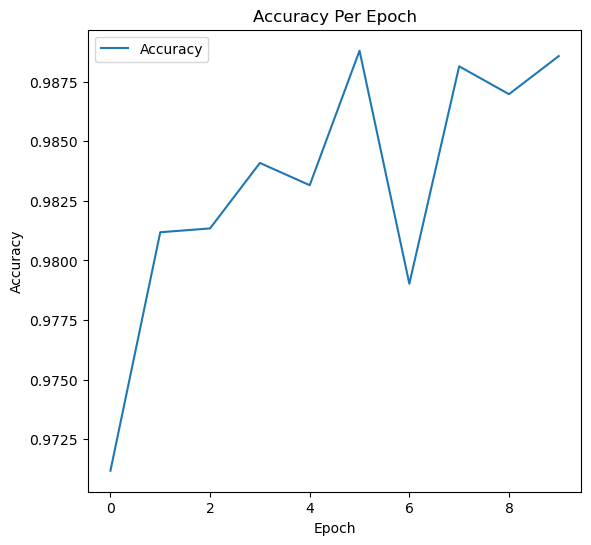

In [13]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(accuracy, label="Accuracy")
plt.title('Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

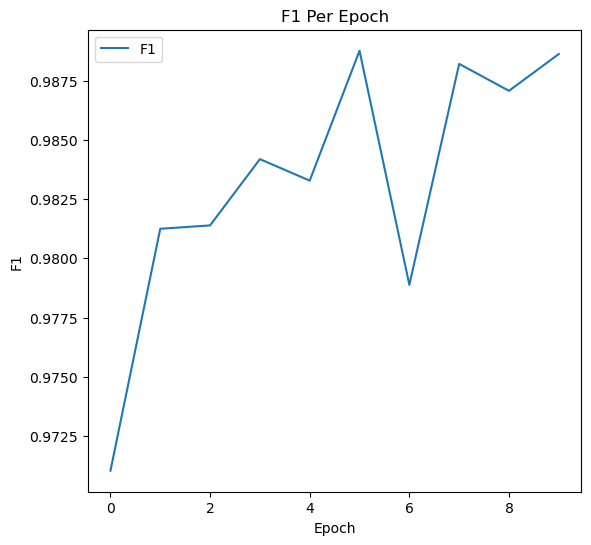

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(f1, label="F1")
plt.title('F1 Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.legend()

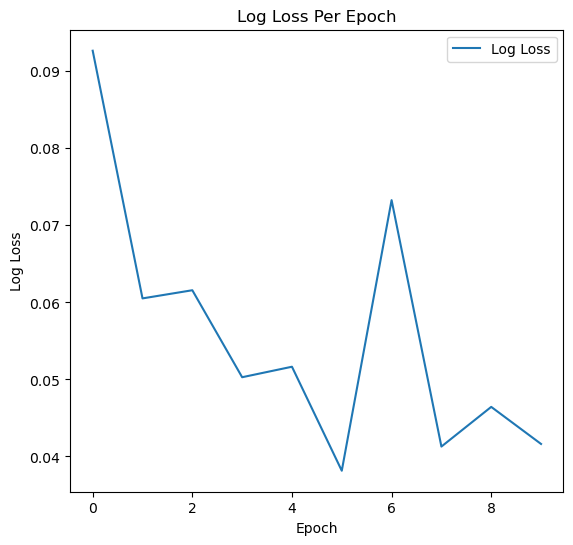

In [15]:
plt.figure(figsize=(14,6))
plt.subplot(1, 2, 1)
plt.plot(log_loss, label="Log Loss")
plt.title('Log Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

[[ 972    0    0    0    0    0    3    1    4    0]
 [   0 1131    1    1    0    0    2    0    0    0]
 [   2    2 1017    0    1    0    1    9    0    0]
 [   0    0    1 1001    0    3    0    1    1    3]
 [   0    0    0    0  971    0    5    2    1    3]
 [   0    1    0    7    0  880    1    0    2    1]
 [   0    4    0    0    1    3  947    0    3    0]
 [   0    4    0    2    2    0    0 1018    0    2]
 [   3    1    1    0    0    2    3    2  960    2]
 [   0    0    0    0   12    0    0    6    1  990]]


<Axes: >

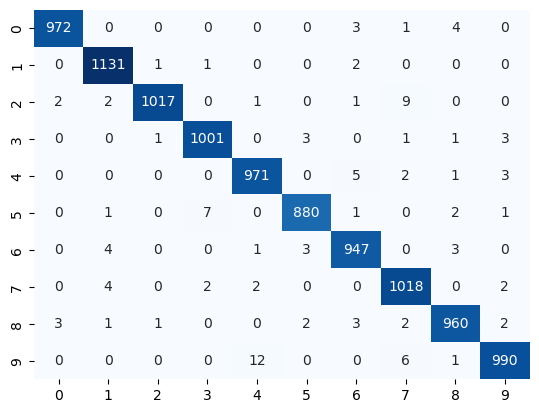

In [16]:
cm = metrics.confusion_matrix(y_test, index)
print(cm)
sns.heatmap(cm, cmap="Blues", cbar=False, annot=True, fmt='d')